In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
show_summary = True
show_dataset_analyze = True

In [5]:
# Load Network and Print Summary
from DeepLib.model import CifarNetDilated
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

In [6]:
from DeepLib.dataset import get_loader
from DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


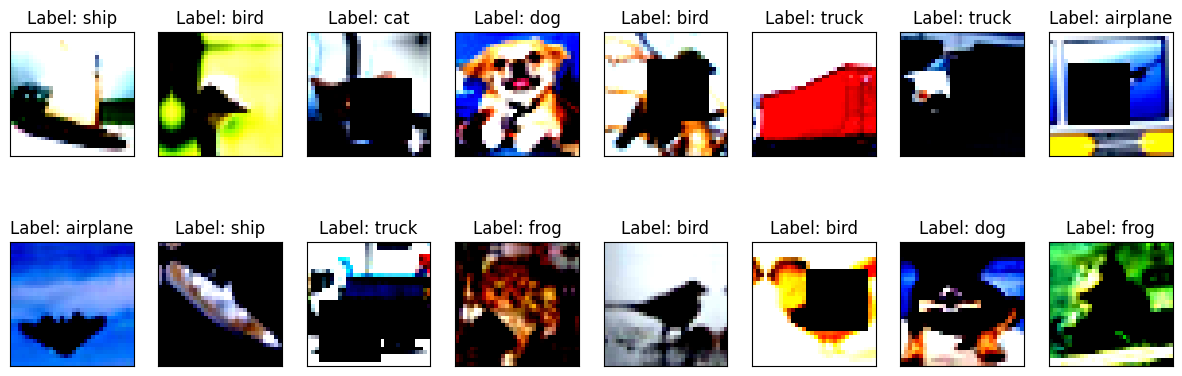

In [7]:
# Calculate Class Scale
from DeepLib.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)#

In [8]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 100
lr = 0.01
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = False
momentum = 0.9
weight_decay = 0.000125

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
model = CifarNetDilated().apply(initialize_weights).to(device)
print_summary(model, input_size=(3, 32, 32))


Using Device: cuda
Epochs: 100
Lr: 0.01
Max Lr: 0.1
Batch Size: 32
Dropout: False


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
         Dropout2d-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 30, 30]           9,216
       BatchNorm2d-5           [-1, 32, 30, 30]              64
         Dropout2d-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 32, 26, 26]           9,216
       BatchNorm2d-8           [-1, 32, 26, 26]              64
         Dropout2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 40, 24, 24]          11,520
      BatchNorm2d-11           [-1, 40, 24, 24]              80
        Dropout2d-12           [-1, 40, 24, 24]               0
           Conv2d-1

| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.010000 | 00m 35s | 1.893653  |        14325 | 28.65  % | 1.504789 |       4477 | 44.77% |
|     2 | 0.014500 | 00m 31s | 1.65946   |        19244 | 38.49  % | 1.385831 |       4908 | 49.08% |
|     3 | 0.019000 | 00m 32s | 1.558887  |        21286 | 42.57  % | 1.273233 |       5401 | 54.01% |
|     4 | 0.023500 | 00m 32s | 1.493312  |        22767 | 45.53  % | 1.200946 |       5644 | 56.44% |
|     5 | 0.028000 | 00m 31s | 1.440744  |        23828 | 47.66  % | 1.137730 |       5866 | 58.66% |
|     6 | 0.032500 | 00m 33s | 1.403392  |        24640 | 49.28  % | 1.107972 |       6078 | 60.78% |
|     7 | 0.037000 | 00m 31s | 1.37033   |        25350 | 50.7   % | 1.112459 |       6049 | 60.49% |
|     8 | 0.041500 | 00m 32s | 1.343722  |        25730 | 51.46  % | 1.039780 |       6263 | 62.63% |
|     9 | 0.046000 | 00m 31s | 1.327056  |        26233 | 52.47  % | 1.025191 |   

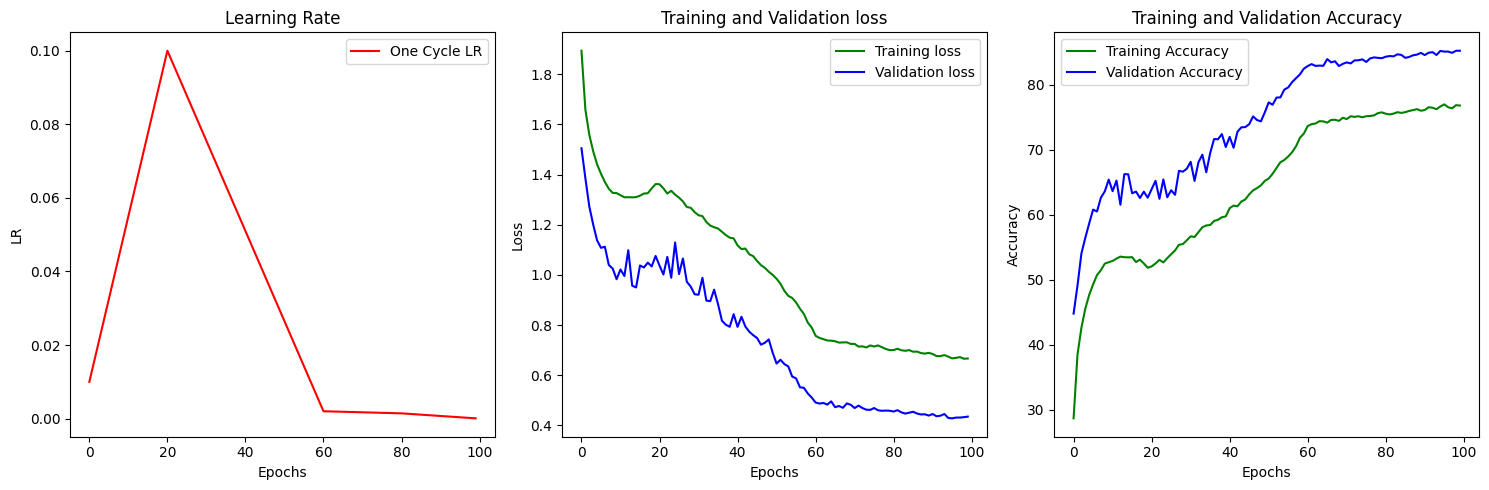

Confusion matrix, without normalization


Total Incorrect Predictions 1476


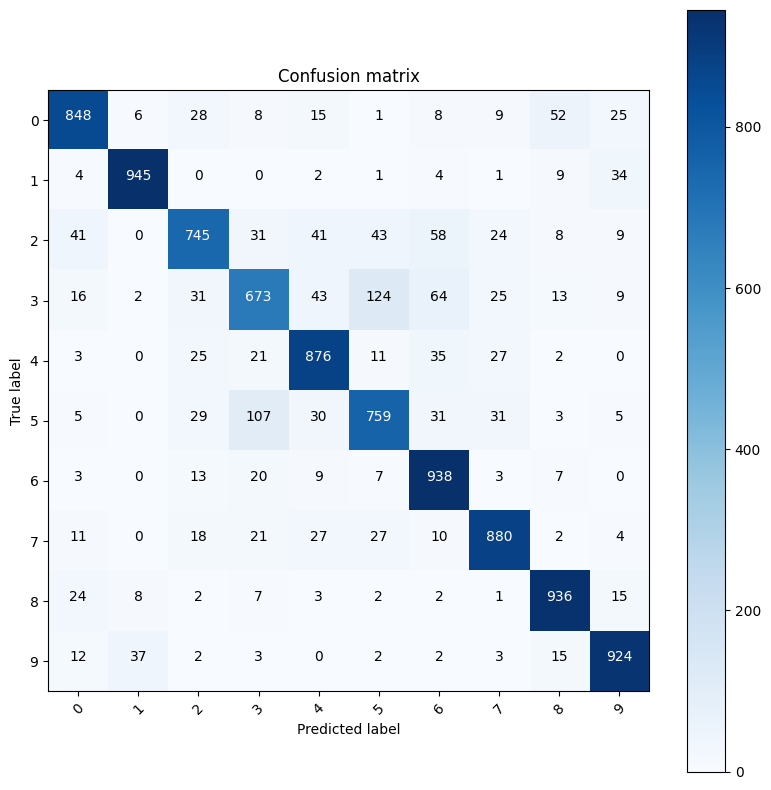

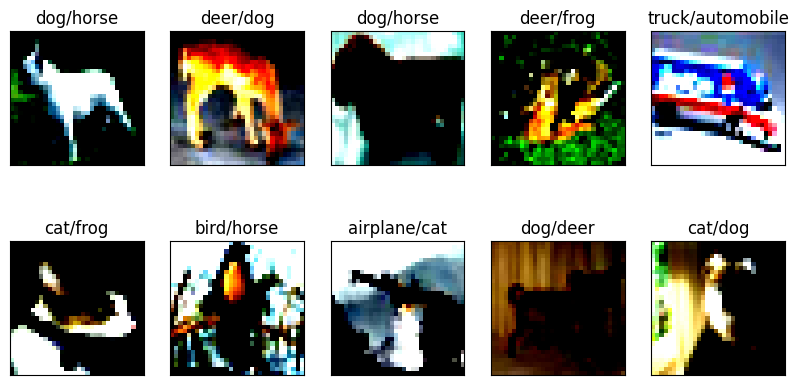

In [9]:
optimizer = get_sgd_optimizer(model, lr=lr, weight_decay=weight_decay)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer,
    lr=lr,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer,
    lr=lr,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

from DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.utils import get_incorrrect_predictions
from DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)